library import

In [5]:
import sys
import sktime
import tqdm as tq
import xgboost as xgb
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np
print("-------------------------- Python & library version --------------------------")
print("Python version: {}".format(sys.version))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))
print("tqdm version: {}".format(tq.__version__))
print("sktime version: {}".format(sktime.__version__))
print("xgboost version: {}".format(xgb.__version__))
print("seaborn version: {}".format(sns.__version__))
print("scikit-learn version: {}".format(skl.__version__))
print("------------------------------------------------------------------------------")

-------------------------- Python & library version --------------------------
Python version: 3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]
pandas version: 1.5.3
numpy version: 1.23.5
matplotlib version: 3.7.0
tqdm version: 4.64.1
sktime version: 0.21.0
xgboost version: 1.7.6
seaborn version: 0.12.2
scikit-learn version: 1.2.1
------------------------------------------------------------------------------


In [1]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
import pandas as pd
import numpy as np
import random
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 

from tqdm.auto import tqdm

In [6]:
font_path = 'C:/Windows/Fonts/NGULIM.TTF'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

시드 고정

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(10) # Seed 고정

데이터 불러오기

In [3]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [21]:
# 빌딩정보
pd.read_csv('./data/building_info.csv')

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000
...,...,...,...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00,-,-,-
96,97,호텔및리조트,55144.67,25880.00,-,-,-
97,98,호텔및리조트,53578.62,17373.75,-,-,-
98,99,호텔및리조트,53499.00,40636.00,-,-,-


In [6]:
# 제출 양식
pd.read_csv('./data/sample_submission.csv')

,num_date_time,answer
0,1_20220825 00,0
1,1_20220825 01,0
2,1_20220825 02,0
3,1_20220825 03,0
4,1_20220825 04,0
...,...,...
16795,100_20220831 19,0
16796,100_20220831 20,0
16797,100_20220831 21,0
16798,100_20220831 22,0


In [5]:
train_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [4]:
test_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77


데이터 전처리

In [4]:
# 일조, 일사 열 제거
train_df = train_df.drop(['일조(hr)','일사(MJ/m2)'], axis=1)
train_df

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,986.40
...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,881.04
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,798.96
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,825.12
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,640.08


In [19]:
# 결측치 확인
train_df.isna().sum()

num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)              19
습도(%)                 9
전력소비량(kWh)            0
dtype: int64

In [5]:
# 강수량 결측치 0.0으로 채우기
train_df['강수량(mm)'].fillna(0.0, inplace=True)

In [6]:
# 건물번호별로 예측해서 날짜별로 더하기
train_df[train_df['건물번호'] == 1] # 1부터 100까지-

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,0.0,0.9,42.0,1085.28
1,1_20220601 01,1,20220601 01,18.0,0.0,1.1,45.0,1047.36
2,1_20220601 02,1,20220601 02,17.7,0.0,1.5,45.0,974.88
3,1_20220601 03,1,20220601 03,16.7,0.0,1.4,48.0,953.76
4,1_20220601 04,1,20220601 04,18.4,0.0,2.8,43.0,986.40
...,...,...,...,...,...,...,...,...
2035,1_20220824 19,1,20220824 19,25.5,0.0,2.9,63.0,2517.12
2036,1_20220824 20,1,20220824 20,25.0,0.0,2.6,66.0,2208.96
2037,1_20220824 21,1,20220824 21,24.6,0.0,1.3,67.0,1806.24
2038,1_20220824 22,1,20220824 22,24.1,0.0,2.1,70.0,1387.20


In [7]:
# 데이터 형식 날짜형식으로 바꾸기
train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')
train_df['일시']

0        2022-06-01 00:00:00
1        2022-06-01 01:00:00
2        2022-06-01 02:00:00
3        2022-06-01 03:00:00
4        2022-06-01 04:00:00
                 ...        
203995   2022-08-24 19:00:00
203996   2022-08-24 20:00:00
203997   2022-08-24 21:00:00
203998   2022-08-24 22:00:00
203999   2022-08-24 23:00:00
Name: 일시, Length: 204000, dtype: datetime64[ns]

In [8]:
# 일별 전력소비량 알아보기 위해 일별 열 추가
train_df['일별'] = train_df['일시'].dt.date
train_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh),일별
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,1085.28,2022-06-01
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,1047.36,2022-06-01
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,974.88,2022-06-01
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,953.76,2022-06-01
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,986.40,2022-06-01


In [9]:
# 건물번호별로 예측해서 날짜별로 더하기
building1 = train_df[train_df['건물번호'] == 1] # 1부터 100까지
building1

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh),일별
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,1085.28,2022-06-01
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,1047.36,2022-06-01
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,974.88,2022-06-01
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,953.76,2022-06-01
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,986.40,2022-06-01
...,...,...,...,...,...,...,...,...,...
2035,1_20220824 19,1,2022-08-24 19:00:00,25.5,0.0,2.9,63.0,2517.12,2022-08-24
2036,1_20220824 20,1,2022-08-24 20:00:00,25.0,0.0,2.6,66.0,2208.96,2022-08-24
2037,1_20220824 21,1,2022-08-24 21:00:00,24.6,0.0,1.3,67.0,1806.24,2022-08-24
2038,1_20220824 22,1,2022-08-24 22:00:00,24.1,0.0,2.1,70.0,1387.20,2022-08-24


In [18]:
일별전력소비량 = building1.groupby('일별')['전력소비량(kWh)'].sum()
일별전력소비량

일별
2022-06-01    43383.84
2022-06-02    50126.88
2022-06-03    54064.32
2022-06-04    49772.16
2022-06-05    40742.88
                ...   
2022-08-20    67040.16
2022-08-21    60162.24
2022-08-22    70400.64
2022-08-23    70459.68
2022-08-24    68825.28
Name: 전력소비량(kWh), Length: 85, dtype: float64

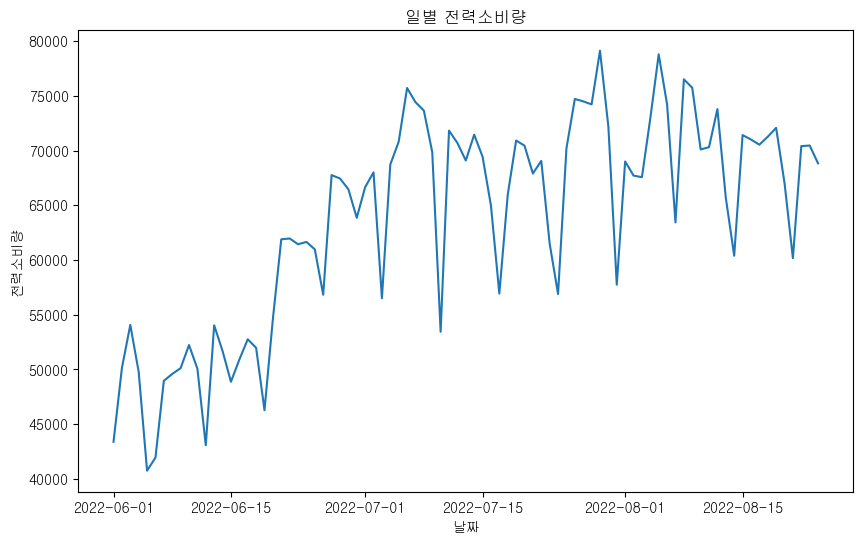

In [17]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=일별전력소비량.index, y= 일별전력소비량)
plt.title('일별 전력소비량')
plt.xlabel('날짜')
plt.ylabel('전력소비량')
plt.show()